# Video Segmentation

Gargeya Sharma - 220278025 - MSc Artificial Intelligence

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm_notebook as tq

plt.rcParams['figure.figsize'] = (11,7)
plt.rcParams["figure.dpi"] = 100

In [2]:
img = cv2.imread("../Dataset/DatasetA/face-1.jpg")

#### For Another Image: Face-2.jpg

In [3]:
img2 = cv2.imread("../Dataset/DatasetA/face-2.jpg")

# a.)

In [4]:
def ICV_count(array):
    """
    Count the Number of instances for each value in the array and 
    store it as key value pair {pixel value: Number of such values in the array}
    """
    freq = {}
    for i in array:
        if i in freq.keys():
            freq[i]+=1
        else:
            freq[i] = 1
    return freq

In [5]:
def ICV_hist_values(counter_dict, bins, BIN_SIZE):
    """
    Create a dictionary with key values as range of bins and values as the frequency of pixel having values in that bin-range
    Number of Bins to create can be adjusted by the argument: BIN_SIZE
    """
    d = dict()
    for i in range(1, BIN_SIZE):
        r = str(bins[i-1])+"-"+str(bins[i])
        d[r] = 0
        for px, times in counter_dict.items():
            if bins[i-1] <= px < bins[i]:
                d[r] = d[r] + times
    ## Because Upper limit is not included in the count, last value in the range would be left out
    ## So, I am explicility adding the count of 255 pixel value iff it exists in comuter_dict in the first place.
    if 255 in counter_dict.keys():
        d[r] = d[r] + counter_dict[255]
    return d

In [6]:
def ICV_colored_histogram(img, normalize=False, plot=False, return_bins_dict=False, bin_size=86):
    chnl = []
    BIN_SIZE = bin_size
    br = np.linspace(0,255,BIN_SIZE)
    for i in range(3):
        temp = ICV_count(img[:,:,i].flatten())
        d = ICV_hist_values(temp, br, BIN_SIZE)
        if normalize:
            new = {}
            for k,v in zip(d.keys(),np.array(list(d.values()))/np.sum(np.array(list(d.values())))):
                new[k] = v
            chnl.append(new)
        else:
            chnl.append(d)
    if plot:
        c = {'b':0, 'g':1, 'r':2}    ## BGR sequence of channels because we are using OpenCV
        for color,index in c.items():
            plt.plot(chnl[index].keys(), chnl[index].values(), c=color) 
        plt.title("Colored Histogram for the Image")
        if normalize:
            plt.ylabel("Normalized Frequency of color in the bin range")
        else:
            plt.ylabel("Frequency of color in the bin range")
        plt.xlabel("Bins of size 3 between 0-255: 85 Bins")
        plt.grid(True)
        plt.xticks([])#list(chnl[0].keys()), rotation=90)
        plt.savefig("temp.jpg",dpi=120)
        plt.show()
        
    hist_freq_array = np.array(list(map(lambda x:np.array(list(x.values())), chnl)))
    if return_bins_dict:
        return chnl
    else:
        return hist_freq_array

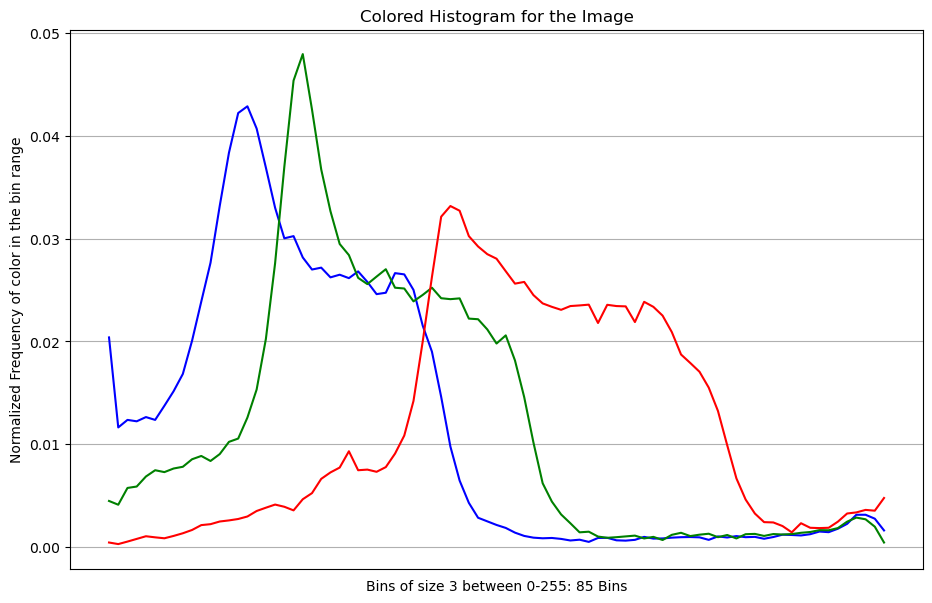

In [7]:
color_freq = ICV_colored_histogram(img, normalize=True, plot=True)

In [8]:
color_freq.shape

(3, 85)

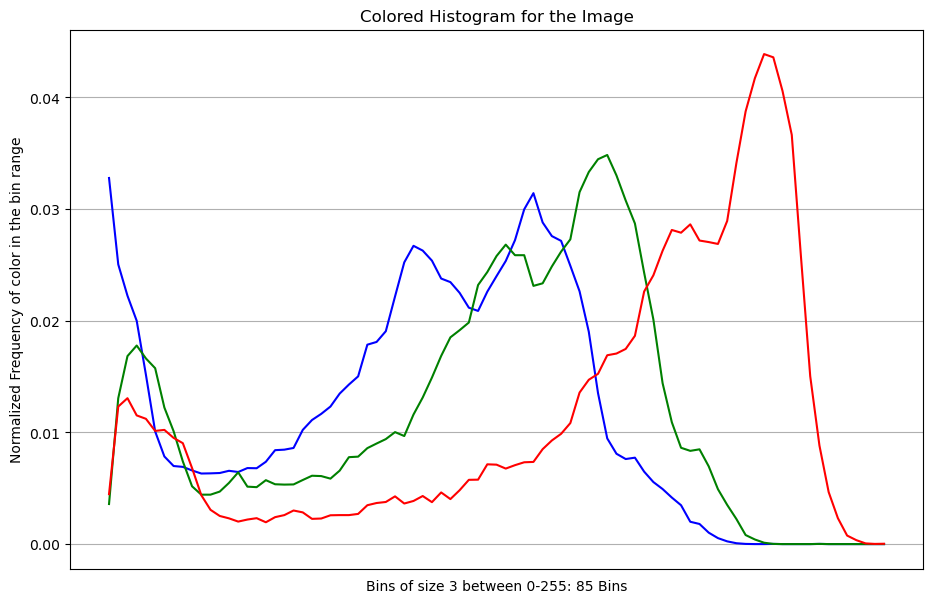

In [9]:
color_freq2 = ICV_colored_histogram(img2, normalize=True, plot=True)

In [10]:
color_freq2.shape

(3, 85)

In [11]:
import cv2
cap = cv2.VideoCapture("../Dataset/DatasetB.avi")

frames = []
while (cap.isOpened()):
    # Read a new frame

    ret, frame = cap.read()
    if ret == True:
        frame = np.array(frame)
        frames.append(frame)
    else:
        break
frames = np.array(frames)
cap.release()

In [12]:
frames.shape

(348, 224, 336, 3)

#### Using the Colored Histrogram function to contrust the histogram for each frame

In [13]:
histograms_per_frame = np.array(list(map(lambda x: ICV_colored_histogram(x, normalize=True), tq(frames))))

  0%|          | 0/348 [00:00<?, ?it/s]

In [14]:
histograms_per_frame.shape

(348, 3, 85)

# b.)

In [15]:
def ICV_intersection(freq_1, freq_2):
    ## np.average is used to normalize the (3,85) frequency matrix for 3 channels into a single value of intersectionn
    return np.average(np.sum(np.minimum(freq_1, freq_2), axis=1))

In [16]:
## Checking if the function is working as expected
ICV_intersection(color_freq, color_freq)

1.0

In [17]:
## Frame(300) and Frame(301) Intersection For Report
ICV_intersection(ICV_colored_histogram(frames[300], normalize=True, plot=False), ICV_colored_histogram(frames[301], normalize=True, plot=False))

0.9781701743197279

In [18]:
def ICV_intersection_frame_couple(frames, normalize=True):
    intersections = []
    for i in tq(range(frames.shape[0]-1)):
        color_freq1 = ICV_colored_histogram(frames[i], normalize, plot=False)
        color_freq2 = ICV_colored_histogram(frames[i+1], normalize, plot=False)
        inter = ICV_intersection(color_freq1, color_freq2)
        intersections.append(inter)
    return intersections

In [19]:
temp = ICV_intersection_frame_couple(frames, normalize=False)

  0%|          | 0/347 [00:00<?, ?it/s]

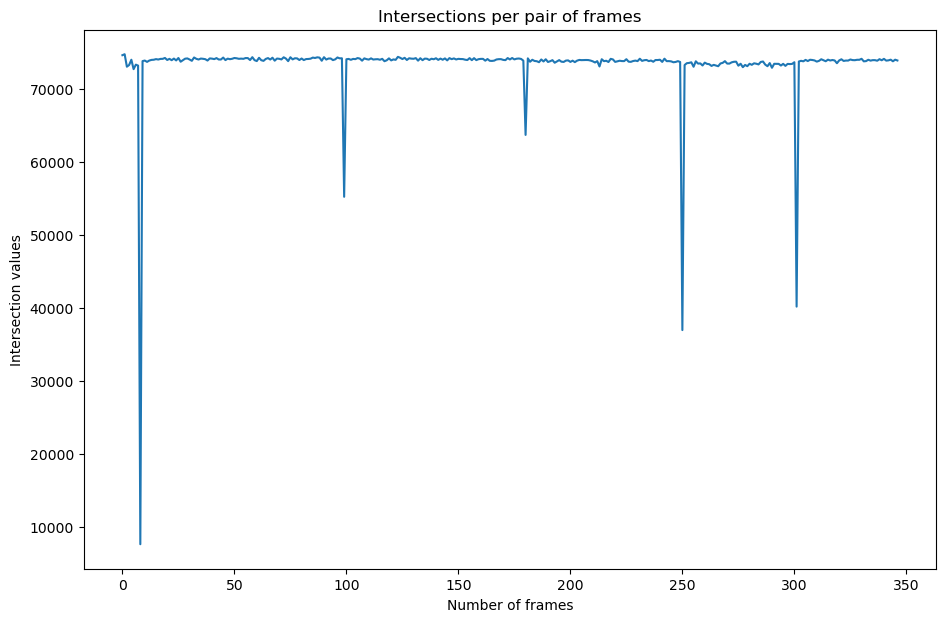

In [20]:
plt.plot(temp)
plt.title("Intersections per pair of frames")
plt.ylabel("Intersection values")
plt.xlabel("Number of frames")
plt.savefig("Intersections per pair of frames.jpg", dpi=120)
plt.show()

In [21]:
temp = ICV_intersection_frame_couple(frames, normalize=True)

  0%|          | 0/347 [00:00<?, ?it/s]

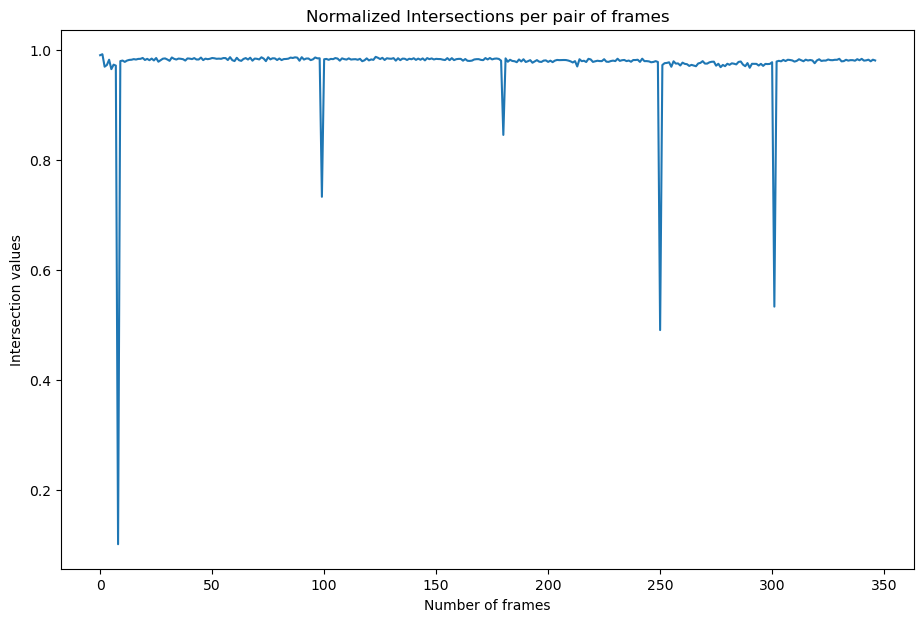

In [22]:
plt.plot(temp)
plt.title("Normalized Intersections per pair of frames")
plt.ylabel("Intersection values")
plt.xlabel("Number of frames")
plt.savefig("Normalized Intersections per pair of frames.jpg", dpi=120)
plt.show()

---